# 🎯 Confidence Score Calibration Demo

<div style="background-color: rgba(200, 200, 200, 0.1); padding: 20px; border-radius: 8px; margin-bottom: 20px; border: 1px solid rgba(127, 127, 127, 0.2); max-width: 97.5%; overflow-wrap: break-word;">
  <p style="font-size: 16px; line-height: 1.6">
     Confidence scores from uncertainty quantification methods may not be well-calibrated probabilities. This demo demonstrates how to transform raw confidence scores into calibrated probabilities that better reflect the true likelihood of correctness using the <code>ScoreCalibrator</code> class.
  </p>
</div>

## 📊 What You'll Do in This Demo

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>1</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold">Generate simulated confidence scores and correctness labels</p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Create realistic example data that mimics UQ results with varying calibration quality.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>2</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold">Compare calibration methods</p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Evaluate uncalibrated scores vs Platt scaling vs Isotonic regression.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 25px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>3</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold">Visualize calibration quality</p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Generate reliability diagrams and compute calibration metrics like ECE and Brier score.</p>
  </div>
</div>

## ⚖️ Calibration Methods

<div style="display: flex; gap: 20px">
  <div style="flex: 1; background-color: rgba(0, 100, 200, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(0, 100, 200, 0.2)">
    <h3 style="color: #1e40af; margin-top: 0">Platt Scaling</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Method:</strong> Logistic regression</li>
      <li><strong>Parametric:</strong> Assumes sigmoid-shaped calibration function</li>
      <li><strong>Best for:</strong> Small datasets, well-behaved score distributions</li>
    </ul>
  </div>
  
  <div style="flex: 1; background-color: rgba(0, 200, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(0, 200, 0, 0.2)">
    <h3 style="color: #2e8b57; margin-top: 0">Isotonic Regression</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Method:</strong> Non-parametric, monotonic</li>
      <li><strong>Flexible:</strong> Can handle any monotonic calibration curve</li>
      <li><strong>Best for:</strong> Larger datasets, complex score distributions</li>
    </ul>
  </div>
</div>

In [24]:
import numpy as np
import pandas as pd

from uqlm.utils.score_evaluator import ScoreEvaluator
from uqlm.utils.score_calibrator import fit_and_evaluate_calibrators
from uqlm.utils import load_example_dataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Generate Simulated Data

For this demo, we'll create simulated confidence scores that mimic real UQ results. We'll generate scores that are poorly calibrated at the outset to demonstrate the calibration methods.

In [25]:
# Set random seed for reproducibility
np.random.seed(42)
n_samples = 1000

# Load example dataset for prompts/answers (optional, for context)
gsm8k = load_example_dataset("gsm8k", n=n_samples)
print(f"Loaded {len(gsm8k)} questions from GSM8K dataset")

# Generate simulated confidence scores with poor calibration characteristics
# Overconfident scores - this mimics a common problem where UQ methods
# produce confidence scores that are systematically too high
overconfident_probs = np.random.beta(0.5, 0.5, n_samples)
overconfident_probs = 0.3 + 0.7 * overconfident_probs
response_correct = np.random.binomial(1, 0.2 + 0.4 * overconfident_probs)

# Create DataFrame
data = {"prompt": gsm8k.question[:n_samples], "response": [f"Response {i}" for i in range(n_samples)], "confidence_score": overconfident_probs, "correct": response_correct.astype(bool), "answer": gsm8k.answer[:n_samples]}

df = pd.DataFrame(data)

df.head()

Using the latest cached version of the dataset since openai/gsm8k couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'main' at /Users/jmabry/.cache/huggingface/datasets/openai___gsm8k/main/0.0.0/e53f048856ff4f594e959d75785d2c2d37b678ee (last modified on Fri Aug 15 10:46:30 2025).


Loading dataset - gsm8k...
Processing dataset...
Dataset ready!
Loaded 1000 questions from GSM8K dataset


,prompt,response,confidence_score,correct,answer
0,Natalia sold clips to 48 of her friends in Apr...,Response 0,0.719445,True,72
1,Weng earns $12 an hour for babysitting. Yester...,Response 1,0.650054,True,10
2,Betty is saving money for a new wallet which c...,Response 2,0.303134,False,5
3,"Julie is reading a 120-page book. Yesterday, s...",Response 3,0.593191,False,42
4,James writes a 3-page letter to 2 different fr...,Response 4,0.300315,True,624


# 2. Diagnosing the Calibration Issue

Let's generate the reliability diagram, score probability distribution,
and the calibration gap for the raw confidence scores. 

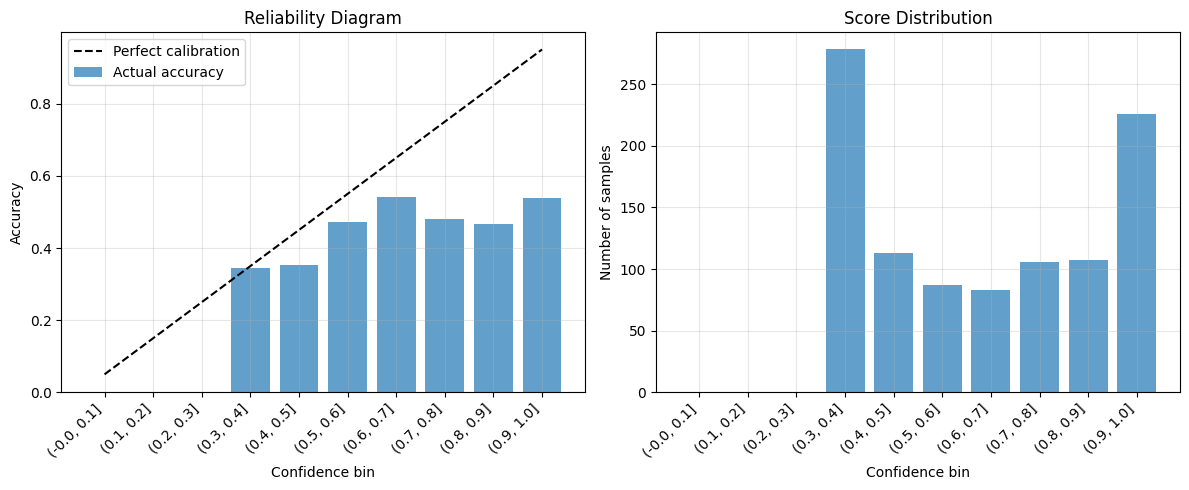

Calibration Metrics:
average_confidence    0.63
average_accuracy      0.44
calibration_gap       0.19


In [16]:
# Create evaluator instance
evaluator = ScoreEvaluator()

calibration_metrics = evaluator.evaluate_calibration(df["confidence_score"], df["correct"], plot=True)

print("Calibration Metrics:")
print(pd.Series(calibration_metrics)[["average_confidence", "average_accuracy", "calibration_gap"]].round(2).to_string())

### What the Plots & Metrics Mean

The large calibration gap (confidence - accuracy ≈ 0.2) indicates that the model is systematically overestimating accuracy by ~20%, making its raw confidence scores unreliable for decision-making.

**Reliability Diagram**:
    - The diagonal line represents perfect calibration (confidence = actual accuracy)
    - The actual accuracy within the data binned by confidence score is well below the diagonal, indicating consistent overconfidence that is worse with higher scores. For example, samples with ~80% confidence are actually correct only ~50% of the time
    
**Score Distribution**:
    - Confidence scores are skewed toward very low (below 0.3) and very high values (many above 0.9).

## 3. Compare Calibration Methods

We'll compare two approaches for calibrating the scores:
- **Platt Scaling**: Logistic regression-based calibration  
- **Isotonic Regression**: Non-parametric, monotonic calibration

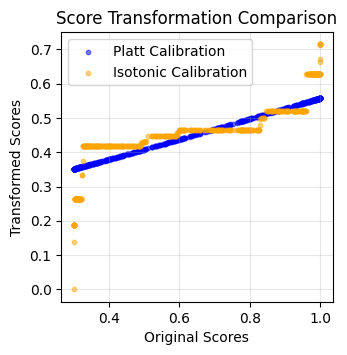

In [19]:
calibrators, comparison_metrics, figures = fit_and_evaluate_calibrators(scores=df["confidence_score"], correct_labels=df["correct"], test_size=0.5, random_state=42, methods=["platt", "isotonic"])
figures["transformation_comparison"]

We can see that the Platt Scaling approach produces a simpler calibration function, without the large shifts for more extreme scores closer to 0 and 1 as compared to the Isotonic Regression approach. 

### Comparison of Calibration Metrics

In [20]:
print(comparison_metrics.round(4))

          average_confidence  average_accuracy  calibration_gap  brier_score  \
method                                                                         
platt                 0.4515             0.444           0.0075       0.2412   
isotonic              0.4584             0.444           0.0144       0.2406   

          log_loss     ece     mce  
method                              
platt       0.6752  0.0377  0.0491  
isotonic    0.7412  0.0343  1.0000  


While we see large reductions in the calibration gap, Brier Score and Expected Classification Error (ECE) for both Platt Scaling and Isotonic Regression, the lower Maximum Calibration Error (MCE) indicates that Platt Scaling may be the better choice for calibration with this small dataset.

### Plot transformation reliability diagrams

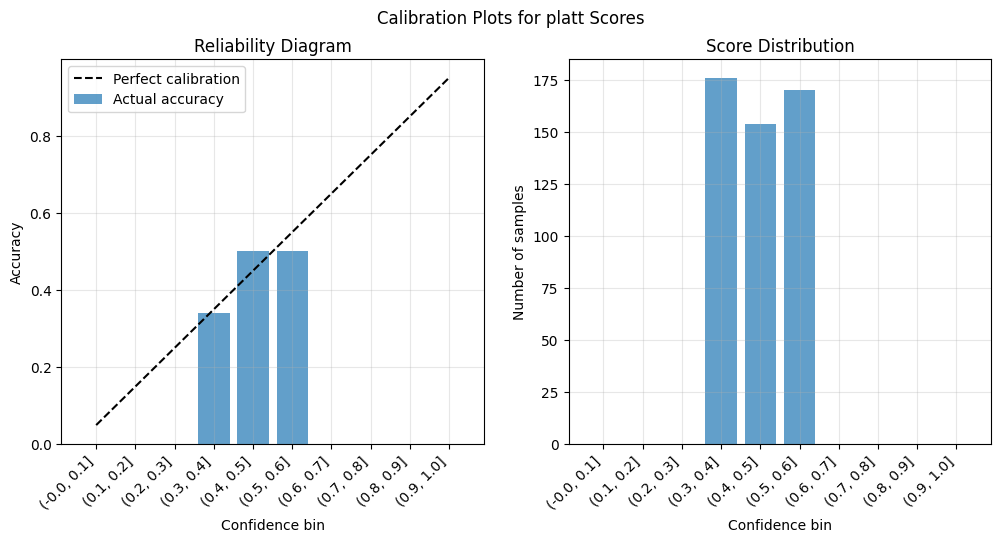

In [21]:
figures["platt_calibration"]

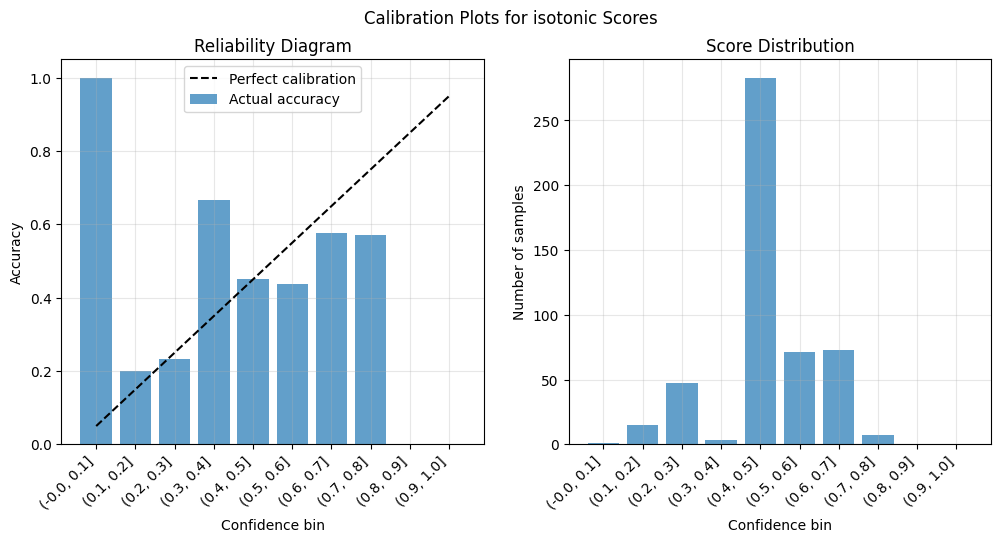

In [22]:
figures["isotonic_calibration"]

In agreement with our metrics, the reliability diagrams that the confidence scores for the simpler Platt Scaling approach are closer to the expected model accuracy than the more aggressive Isotonic Regression approach. 


In [23]:
# To use the fitted calibrators, you can transform your scores like this:
platt_calibrator = calibrators["platt"]

platt_scores = platt_calibrator.transform(df["confidence_score"])

## 4. Summary

This calibration analysis demonstrates:

### 🎯 **Key Findings**

1. **Calibration Quality**: Use reliability diagrams and metrics like ECE and MCE score to assess how well confidence scores reflect true probabilities

2. **Method Selection**: 
   - **Platt Scaling** works well for smaller datasets and when the calibration curve is roughly sigmoid-shaped
   - **Isotonic Regression** is more flexible and can handle complex, non-parametric calibration curves

3. **Practical Impact**: Calibration can significantly improve:
   - Reliability of confidence scores for decision-making
   - User trust in model predictions

### 📚 **Next Steps**

- Apply calibration to your own UQ results using `fit_and_evaluate_calibrators()`
- Use reliability diagrams to visualize calibration quality
- Integrate calibrated scores into your decision-making pipeline

---

© 2025 CVS Health and/or one of its affiliates. All rights reserved.